In [7]:
import dask
dask.config.set({"dataframe.query-planning": False})

import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append("../../../workflow/scripts/")

import _utils
import readwrite
cfg = readwrite.config()
sns.set_style('ticks')

# Params

In [ ]:
# cfg paths
xenium_processed_data_dir = Path(cfg['xenium_processed_data_dir'])
xenium_count_correction_dir = Path(cfg['xenium_count_correction_dir'])
xenium_std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
xenium_cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])
std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
scrnaseq_processed_data_dir = Path(cfg['scrnaseq_processed_data_dir'])
seurat_to_h5_dir = results_dir / 'seurat_to_h5'

# Params
use_batch = True
signal_integrity_thresholds = [0.5, 0.7]
correction_methods = ['raw','split_fully_purified',f'resolvi_panel_{use_batch=}',f'resolvi_panel_supervised_{use_batch=}']
correction_methods += [f'ovrlpy_correction_{signal_integrity_threshold=}' for signal_integrity_threshold in signal_integrity_thresholds]
num_samples = 30
mixture_k = 50
normalisation = 'lognorm'
layer = 'data'
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2.1'
segmentation_palette = pd.read_csv(palette_dir / 'col_palette_segmentation.csv', index_col=0).iloc[:, 0]
count_correction_palette = pd.read_csv(palette_dir / 'col_palette_correction_method.csv', index_col=0).iloc[:, 0]
sample_palette = pd.read_csv(palette_dir / 'col_palette_sample.csv', index_col=0).iloc[:, 0]
cell_type_palette_path = palette_dir / 'col_palette_cell_types_combo.csv'


if level == "Level2.1":
    palette_lvl2 = (
        pd.read_csv(cell_type_palette_path)[["Level2", "cols_Level2"]].drop_duplicates().set_index("Level2").squeeze()
    )
    cell_type_palette = pd.read_csv(cell_type_palette_path)[[level, f"cols_{level}"]].drop_duplicates().set_index(level).squeeze()
    for k, v in palette_lvl2.items():
        if k not in cell_type_palette.index:
            cell_type_palette[k] = palette_lvl2[k]
            
    cell_type_palette['malignant cell'] = cell_type_palette['malignant cell of lung']

else:
    cell_type_palette = pd.read_csv(cell_type_palette_path)[[level, f"cols_{level}"]].drop_duplicates().set_index(level).squeeze()

list_n_markers = [10, 20, 30, 40, 50]
radius = 15
n_neighbors = 15
n_permutations = 30
n_splits= 5
n_repeats = 5
top_n = 20
scoring = 'precision'
markers_mode = 'diffexpr'
cv_mode = 'spatial'

xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
order = ['breast','chuvio','lung','5k']

hue_segmentation = "segmentation"
hue_segmentation_order = [
    "MM 0µm",
    "MM",
    "MM 15µm",
    "0µm",
    "5µm",
    "15µm",
    "Baysor",
    "ProSeg",
    "ProSeg mode",
    "Segger",
]

hue_correction = 'correction_method'
hue_correction_order = [
    'raw',
    'ResolVI',
    'ResolVI supervised',
    'ovrlpy 0.5',
    'ovrlpy 0.7',
    'SPLIT',
]

rank_metrics = ["importances"]
plot_metrics = ['hypergeometric_pvalue','NES',f"n_hits_{top_n=}"]
labels_key = level



## Read diffusion index

In [140]:
df_diffusion = pd.read_parquet('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/mbilous/data/xenium_paper/xenium/processed/summary_dfs/w2_neight_w2_cor_paired.parquet')
df_diffusion['panel'] = df_diffusion['Panel'].map({'Lung':'lung','5K':'5k'})
df_diffusion[['cti', 'ctj']] = df_diffusion[['first_type', 'second_type']].replace(r" of .+", "", regex=True)

## Read logreg results

In [5]:
dfs = readwrite.read_contamination_metrics_results(
    results_dir,
    correction_methods,
    xenium_std_seurat_analysis_dir,
    reference,
    method,
    level,
    mixture_k,
    num_samples,
    normalisation,
    layer,
    radius=radius,
    n_splits=n_splits,
    n_permutations=n_permutations,
    n_repeats=n_repeats,
    top_n=top_n,
    markers_mode=markers_mode,
    cv_mode=cv_mode,
    scoring=scoring,

    evaluation = "logreg",
    genes_name='all', #'Xenium_hLung_v1_metadata', 
    train_mode='multivariate',#'univariate',
    # ref_panel='5k',
)

Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Level1 for melanoma	
Using external_reference for melanoma	
Using Leve

Processing futures:  88%|████████▊ | 1827/2082 [02:17<00:12, 20.33it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/0PSV/0P

Processing futures:  88%|████████▊ | 1830/2082 [02:17<00:14, 17.21it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GVD/1G

Processing futures:  91%|█████████ | 1885/2082 [02:20<00:10, 18.47it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC

Processing futures:  93%|█████████▎| 1942/2082 [02:24<00:07, 19.63it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1

Processing futures:  94%|█████████▍| 1954/2082 [02:24<00:06, 18.98it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x

Processing futures:  94%|█████████▍| 1964/2082 [02:25<00:06, 17.76it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSC

Processing futures:  99%|█████████▉| 2061/2082 [02:32<00:01, 19.69it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GAC

Processing futures: 100%|██████████| 2082/2082 [02:33<00:00, 13.56it/s]


## Get precision scores

In [156]:
segmentation = '5µm'
correction_method = 'raw'
ref_panel = '5k'
cti = 'plasma cell'
ctj = 'malignant cell'

df_precision = _utils.get_df_permutations_logreg_plot(dfs['df_permutations_logreg'],[correction_method]).query("segmentation == @segmentation")
# df_precision = df_precision.query("panel == @ref_panel and cti == @cti and ctj == @ctj")

In [157]:
df_precision_cti_ctj = df_precision.query("panel == @ref_panel and cti == @cti and ctj == @ctj")
df_diffusion_cti_ctj = df_diffusion.query("panel == @ref_panel and cti == @cti and ctj == @ctj")

df_precision_cti = df_precision.query("panel == @ref_panel and cti == @cti")
df_diffusion_cti = df_diffusion.query("panel == @ref_panel and cti == @cti")

df_precision_ctj = df_precision.query("panel == @ref_panel and ctj == @ctj")
df_diffusion_ctj = df_diffusion.query("panel == @ref_panel and ctj == @ctj")

df_joint_cti_ctj = pd.merge(df_precision_cti_ctj,df_diffusion_cti_ctj,how='left',on=['condition', 'panel', 'donor', 'sample', 'cti', 'ctj']).dropna()
df_joint_cti = pd.merge(df_precision_cti,df_diffusion_cti,how='left',on=['condition', 'panel', 'donor', 'sample', 'cti', 'ctj']).dropna()
df_joint_ctj = pd.merge(df_precision_ctj,df_diffusion_ctj,how='left',on=['condition', 'panel', 'donor', 'sample',  'cti', 'ctj']).dropna()

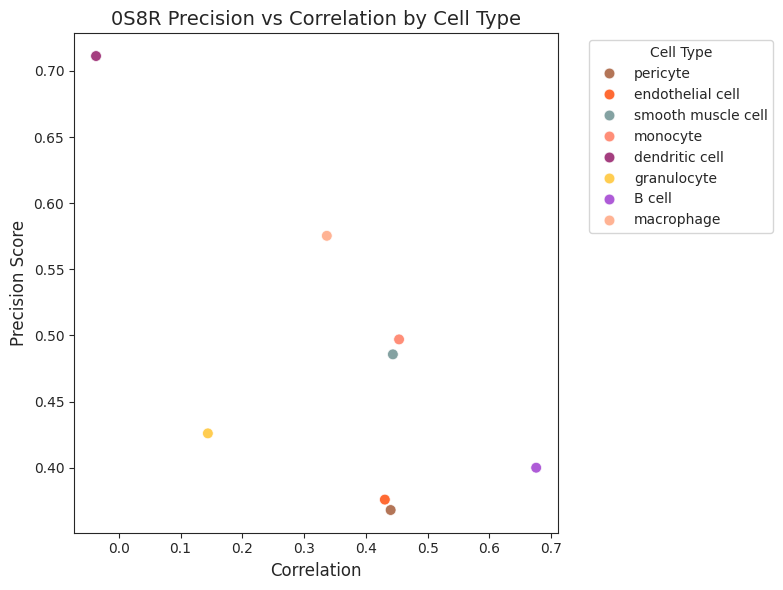

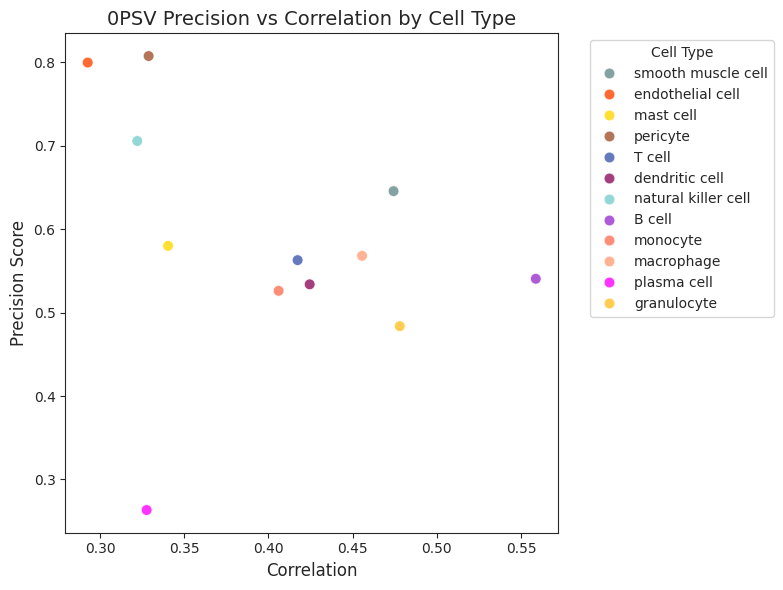

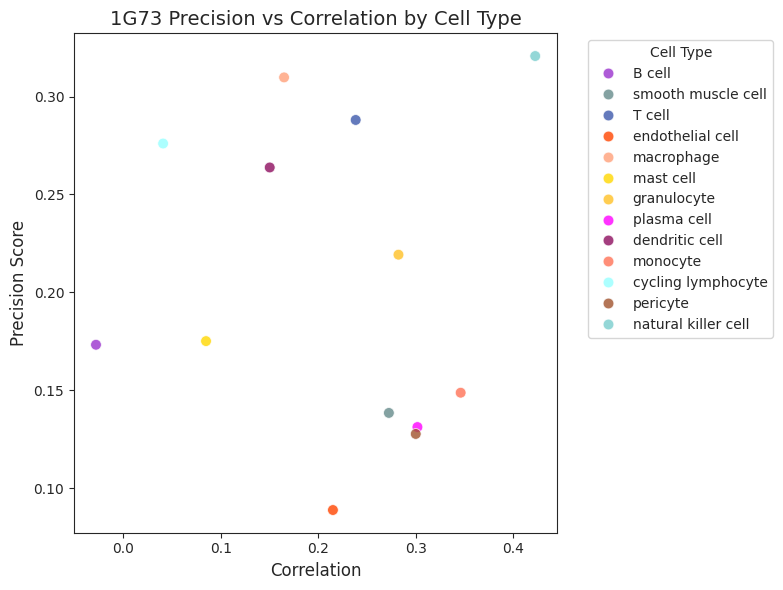

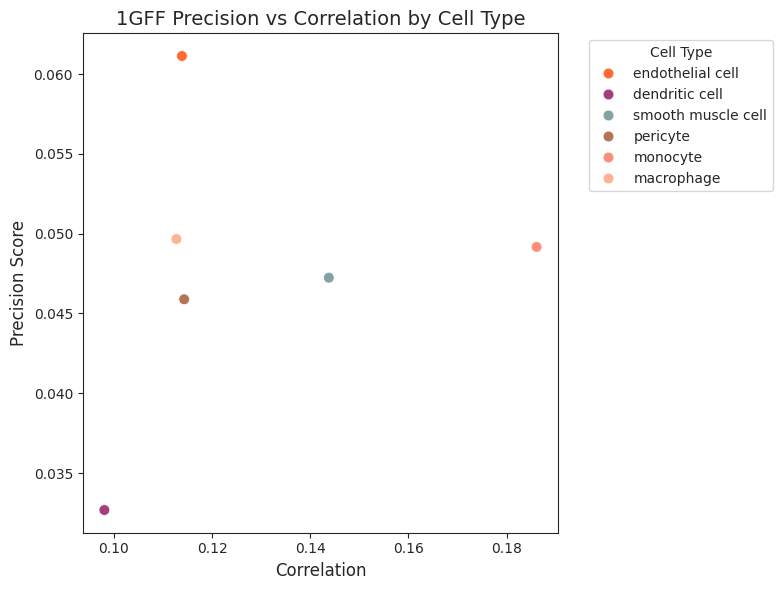

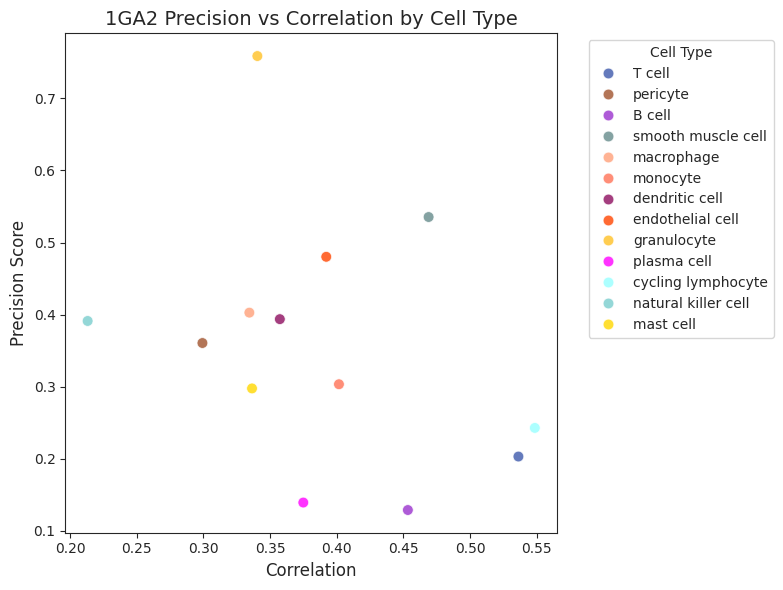

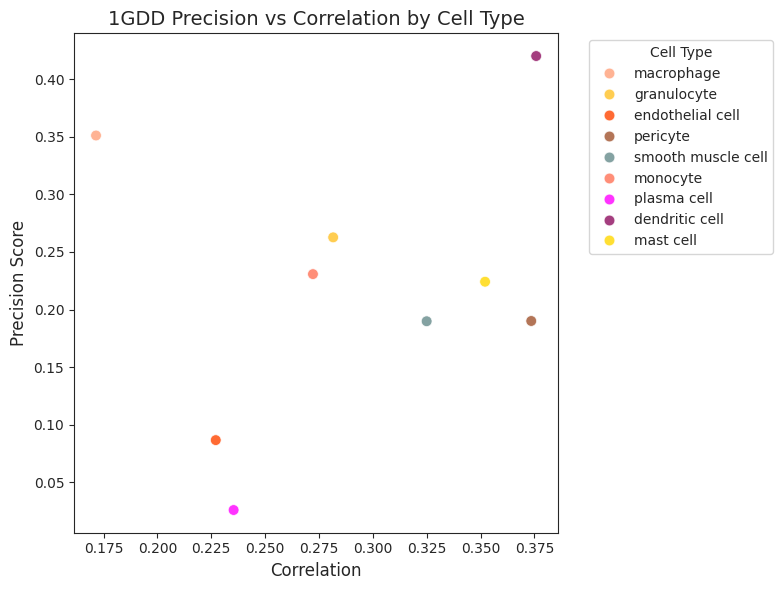

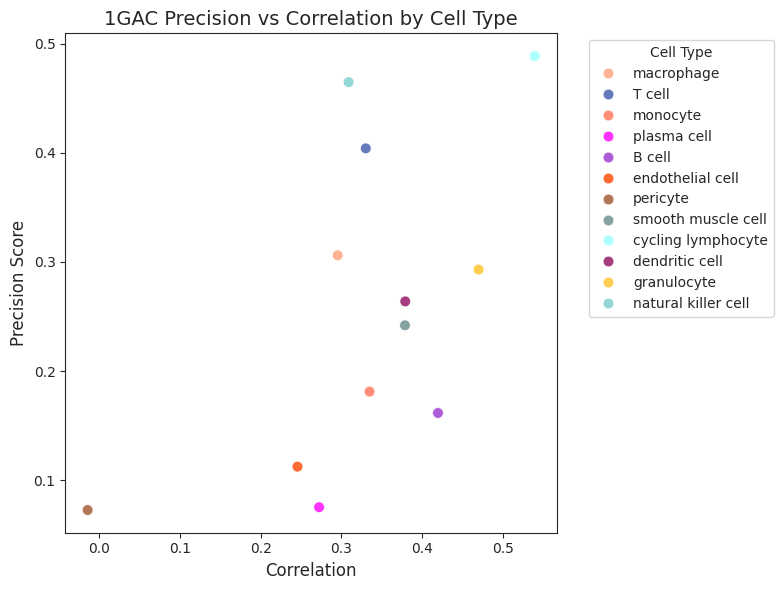

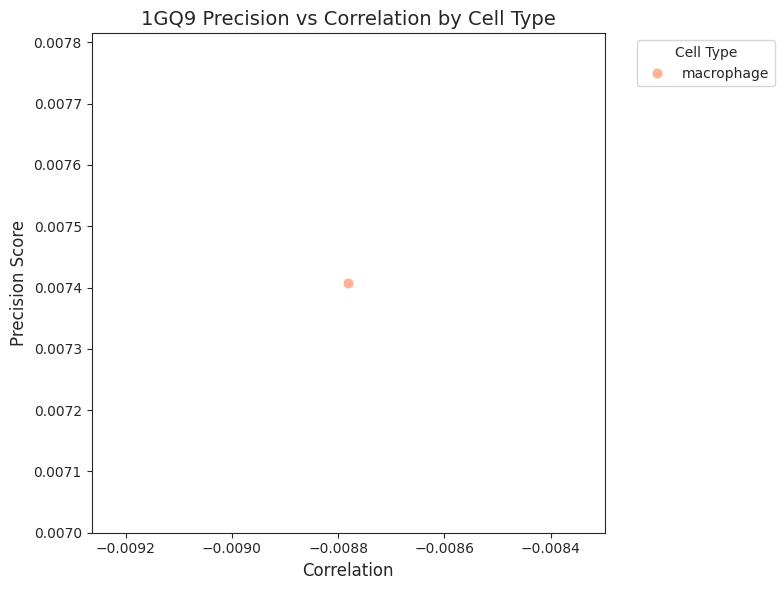

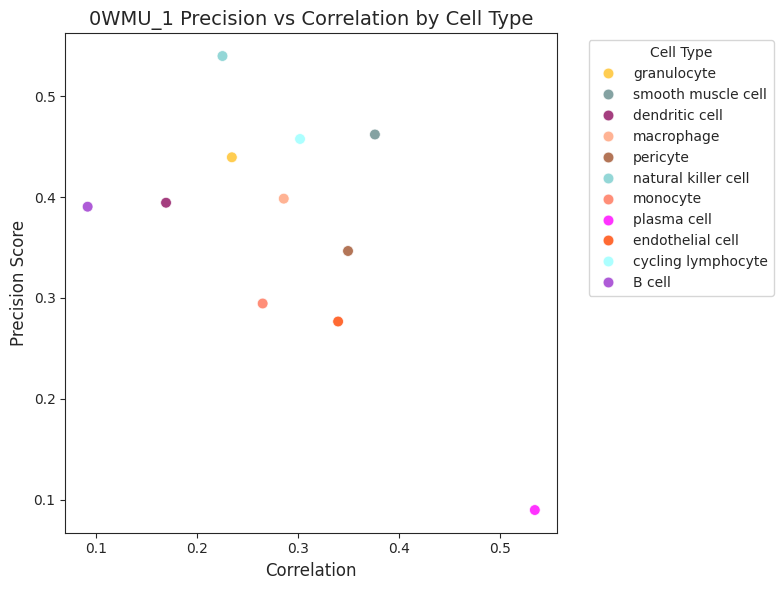

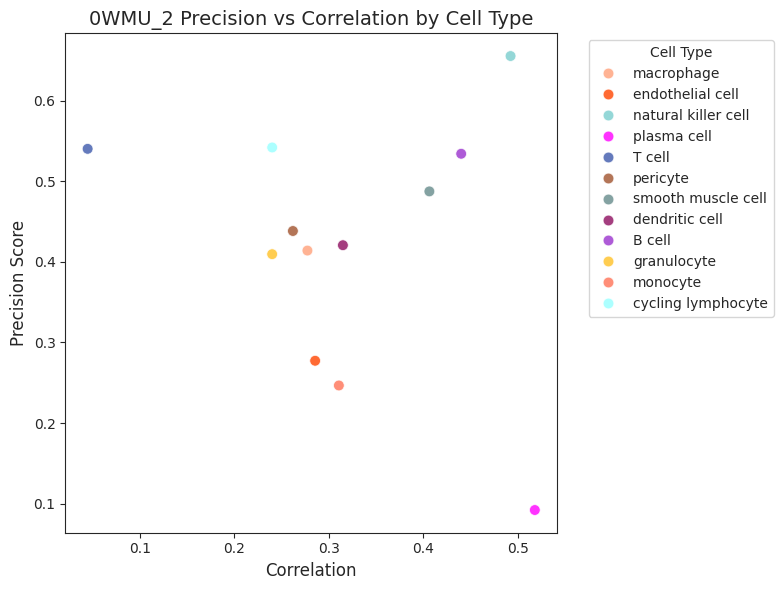

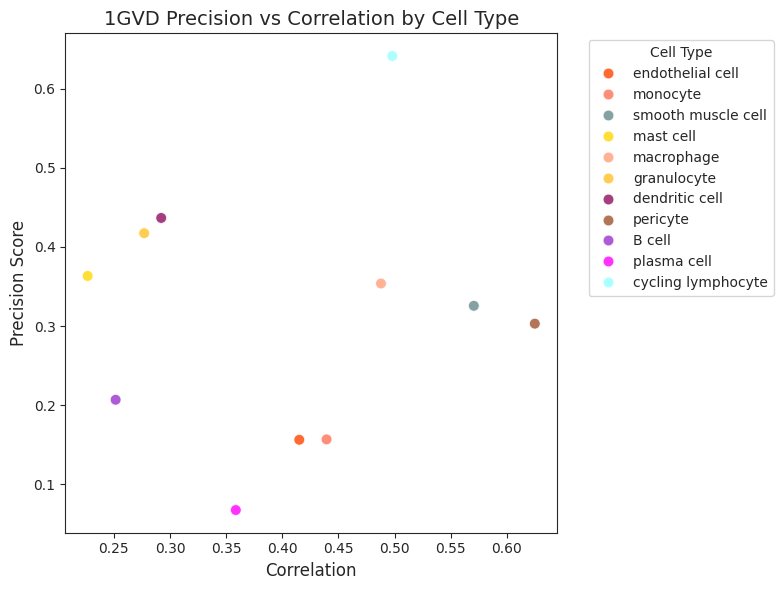

In [133]:
for sample in df_joint_ctj['sample'].unique():

    plt.figure(figsize=(8, 6))
    ax = sns.scatterplot(
        data=df_joint_ctj[df_joint_ctj['sample'] == sample],
        x='cor',
        y='precision_score',
        hue='cti',
        palette=cell_type_palette.to_dict(),
        s=60,      # point size
        alpha=0.8  # slight transparency
    )

    # Move legend outside
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cell Type')

    # Add labels and title
    ax.set_xlabel("Correlation", fontsize=12)
    ax.set_ylabel("Precision Score", fontsize=12)
    ax.set_title(f"{sample} Precision vs Correlation by Cell Type", fontsize=14)

    plt.tight_layout()
    plt.show()